# ML. Практика 2.2. Логистическая регрессия

Теперь вы сотрудник лаборатории, производящей процессоры.  
У вас есть данные о прохождении процессором 2-ух тестов, которые определяют его исправность.
Кроме того, данные размечены, т.е.   
исправные процессоры помечены меткой 1, остальные 0.

Ваша задача - заполнить код в функциях:
- logistic - вычисляет логистическую функцию от аргумента,
- compute_cost_reg - вычисляет функцию стоимости c регуляризацией,
- compute_cost_grad_reg - вычисляет градиент функции стоимости с регуляризацией.

В данной задаче будет использоваться *градиентный метод оптимизации*, определенный в библиотеке *scipy*, так что
не нужно реализовывать градиентный спуск.

**Комментарии к графикам:**  
Первый график - исходные данные.  
Второй - исходные данные с результатом работы модели - границей решений.  
Черным цветом обозначено поле, попадание точки в которое означает ее
принадлежность к 1 классу (процессор исправен), белым - принадлежность к 0 классу (не исправен).

In [17]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [18]:
def map_features(X):

    # Эта функция добавляет все комбинации признаков 2, 3, ..., 6 степеней в матрицу данных.
    # Это нужно для того, чтобы мы могли построить нелинейную границу решений.
    # При таком большом количестве признаков может возникнуть проблема переобучения
    # С ней мы и поборемся с помощью регуляризации.

    result = list()
    for k in range(X.shape[0] if len(X.shape) == 2 else 1):
        vec = list(X[k, :] if len(X.shape) == 2 else X)
        for i in range(2, 7):
            for j in range(i + 1):
                vec.append(vec[1] ** j * vec[2] ** (i - j))
        result.append(vec)
    return np.array(result)

In [19]:
def logistic(z):

    # Функция принимает аргумент z - скаляр, вектор или матрицу в виде объекта numpy.array()
    # Должна возвращать скяляр, вектор или матрицу (в зависимости от размерности z)
    # результатов вычисления логистической функции от элементов z

    result = np.zeros(z.shape)  # результат, его нужно посчитать
    
    result = 1 / (1 + np.exp(-z))

    return result

In [96]:
def compute_cost_reg(X, y, theta, lamb):

    # Функция принимает матрицу данный X, вектор целевых переменных y и вектор параметров theta.
    # Кроме того, функция принимает параметр регуляризации lamb.
    # Должна возвратить число - результат вычисления функции стоимости в точке theta.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    cost = 0  # значение функции стоимости при заданных параметрах, его нужно посчитать

    cost = 1/m * np.sum(-y @ np.log(logistic(X @ theta)) - (1 - y) @ np.log(1 - logistic(X @ theta))) \
           + lamb/m * np.sum(theta ** 2)

    return cost

In [91]:
def compute_cost_grad_reg(X, y, theta, lamb):
    # Функция принимает матрицу данный X, вектор целевых переменных y и вектор параметров theta.
    # Кроме того, функция принимает параметр регуляризации lamb.
    # Должна возвратить вектор координат градиента функции стоимости в точке theta.
    # Вектор можно заполнять в виде списка python. При возврате он преобразуется в массив numpy.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    grad = [0] * n  # вектор градиента функции стоимости по theta, его нужно заполнить

    y = y[:, np.newaxis]
    theta = theta[:, np.newaxis]
    
    error = (logistic(X @ theta) - y).ravel()  # ravel уменьшит многомерный массив до одного измерения
    # error (100, )
    for j in range(n):
        temp = np.multiply(error, X[:, j])
        # temp (100, )
        temp_2 = np.sum(temp) / m
        grad[j] = theta[j] - temp_2 - lamb * theta[j]

    return np.array(grad)

In [72]:
def load_data(data_file_path):
    with open(data_file_path) as input_file:
        X = list()
        y = list()
        for line in input_file:
            *row, label = map(float, line.split(','))
            X.append([1] + row)
            y.append(label)
        return np.array(X, float), np.array(y, float)

In [73]:
X, y = load_data('lab2data2.txt')

X = map_features(X)

In [74]:
print(f'logistic(0) = {np.round(logistic(np.array(0)), 5)} (должно быть 0.5)\n'
      f'logistic(-10) = {np.round(logistic(np.array(-10)), 5)} (должно быть ~0)\n'
      f'logistic(10) = {np.round(logistic(np.array(10)), 5)} (должно быть ~1)')

logistic(0) = 0.5 (должно быть 0.5)
logistic(-10) = 5e-05 (должно быть ~0)
logistic(10) = 0.99995 (должно быть ~1)


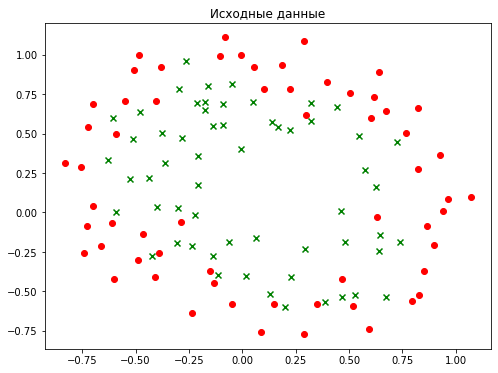

In [75]:
plt.figure(figsize=(8, 6))
plt.title('Исходные данные')
plt.scatter(X[y == 0][:, 1], X[y == 0][:, 2], c='r', marker='o')
plt.scatter(X[y == 1][:, 1], X[y == 1][:, 2], c='g', marker='x');

In [97]:
lamb = 1.0
init_theta = np.zeros((X.shape[1], 1))
cost0 = compute_cost_reg(X, y, init_theta, lamb)
print(f'Функция стоимости при начальном theta = {np.round(cost0, 3)} (должно быть ~0.693)')

Функция стоимости при начальном theta = 0.693 (должно быть ~0.693)


In [92]:
opt_theta_obj = minimize(lambda th: compute_cost_reg(X, y, th, lamb), init_theta,
                         method='CG',
                         jac=lambda th: compute_cost_grad_reg(X, y, th, lamb),
                         options={'gtol': 1e-5, 'maxiter': 1500, 'disp': False})

print('Минимизация функции стоимости ' + ('прошла успешно.' if opt_theta_obj.success else 'не удалась.'))
opt_theta = opt_theta_obj.x

opt_cost = compute_cost_reg(X, y, opt_theta, lamb)
print(f'Функция стоимости при оптимальном theta = {np.round(opt_cost, 3)} (должно быть ~0.529)')

ValueError: shapes (28,1) and (28,1) not aligned: 1 (dim 1) != 28 (dim 0)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_8924/1377020857.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolor(np.arange(-2, 2, 0.05), np.arange(-2, 2, 0.05), hm, cmap='Greys')


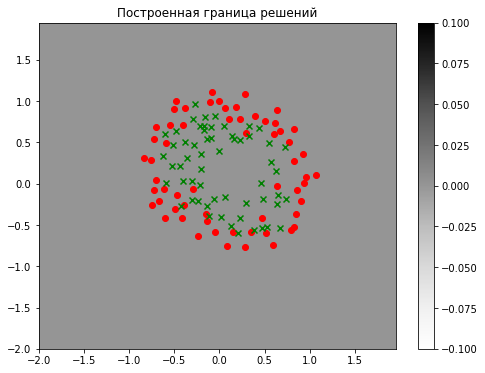

In [78]:
hm = np.zeros((80, 80))
for i in range(80):
    for j in range(80):
        hm[i, j] = round(logistic(opt_theta @ map_features(np.array([1, j / 20 - 2, i / 20 - 2])).transpose())[0])
        
plt.figure(figsize=(8, 6))        
c = plt.pcolor(np.arange(-2, 2, 0.05), np.arange(-2, 2, 0.05), hm, cmap='Greys')
plt.colorbar(c)
plt.title('Построенная граница решений')
plt.scatter(X[y == 0][:, 1], X[y == 0][:, 2], c='r', marker='o')
plt.scatter(X[y == 1][:, 1], X[y == 1][:, 2], c='g', marker='x');